___
# **Insper - Ciência dos Dados**

## **Projeto 3:**

Membros:
* Antonio Vieira Fuziy
* Willian Kenzo
* Ramon Menegatto
* André Rocco

___
### Pergunta e Contexto:

* A base de dados escolhida pelo grupo foi retirada do site Kaggle, esse DataFrame é fictício e foi criado por cientistas de dados da IBM com a finalidade de gerar um desafio para que as pessoas tentassem analisar atributos e o desempenho de funcionários da IBM HR Analytics. Assim, a partir desses dados o desafio do nosso grupo seria analisar não só o desempenho e os atributos dos funcionários da IBM, mas também tentar prever a demissão ou saída de um funcionário com auxílio de machine learning.

**Link para a base de dados:** [IBM HR Analytics Employee Attrition & Performance](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset)

**DataFrame principal do projeto:** `IBM`

* Utilizando a base de dados da empresa, formulamos a seguinte pergunta:

    Qual seriam os parâmetros e as variáveis que influenciam na saída de funcionários da empresa, e a partir dessas variáveis, quais seriam os perfis das pessoas que podem acabar saindo por opinião própria ou sendo demitidas da empresa?

___
**Importando Bibliotecas:**

In [440]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss
from xgboost import XGBClassifier
from sklearn import datasets, linear_model, metrics 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


In [441]:
#Importando Excel:
IBM_semfiltro = pd.read_csv('IBM.csv')

#Filtrando colunas do DataFrame:
IBM = IBM_semfiltro.drop(columns=['EmployeeCount','StandardHours','Over18','DailyRate'])

IBM.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,Sales,1,2,Life Sciences,1,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,Research & Development,8,1,Life Sciences,2,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,Research & Development,2,2,Other,4,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,Research & Development,3,4,Life Sciences,5,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,Research & Development,2,1,Medical,7,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [442]:
#Criando DataFrame que substitui a coluna Attrition = 'Yes' por 1:
IBM.loc[IBM['Attrition'] == 'Yes', 'Attrition'] = 1

#Criando DataFrame que substitui a coluna Attrition = 'No' por 0:
IBM.loc[IBM['Attrition'] == 'No', 'Attrition'] = 0

___
* **Gráfico de Correlação das variáveis do DataFrame:**

___
**Legenda:**
* **Vermelho:  Correlação Positiva**
* **Azul:  Correlação Negativa**

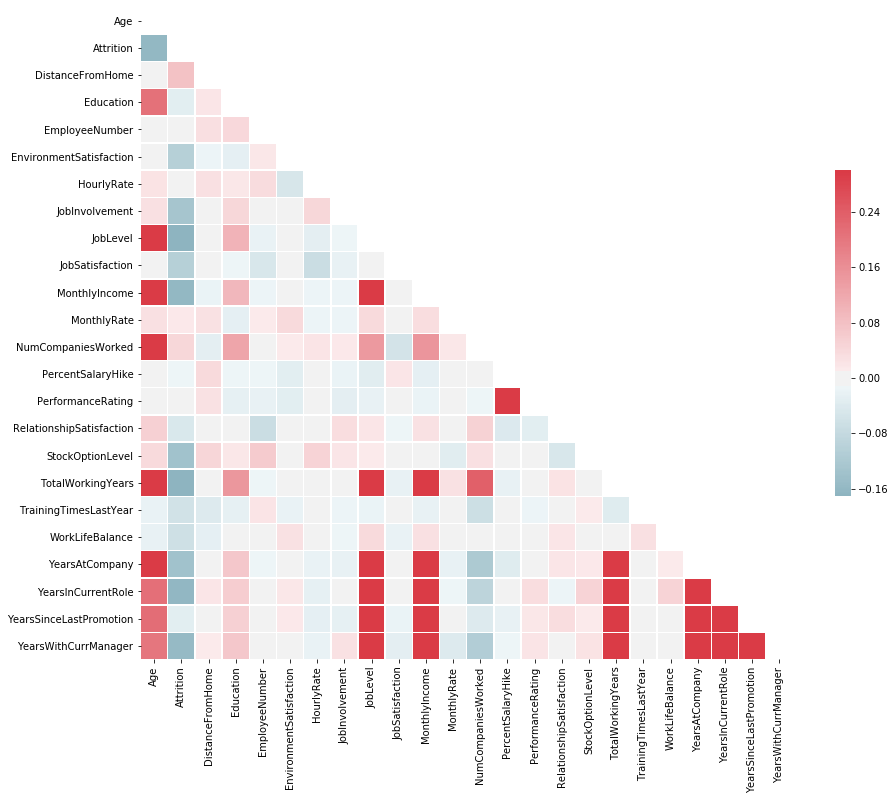

In [443]:
#Criando correlação das variáveis:
corr=IBM.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#Setando a figura:
f, ax = plt.subplots(figsize=(15, 12))

#Gerando as cores do as corelações:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Printando Matriz de correlação:
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Nesse gráfico feito por heatmap conseguimos detectar que diversas de nossas variáveis possuem correlações entre si, mesmo se consideradas baixas, como idade e anos na empresa, ou salário mensal e idade, o que já era esperado

___
* **Gráfico de correlação das variáveis da empresa plotado de forma diferente para ter uma visualização diferente do gráfico acima:**

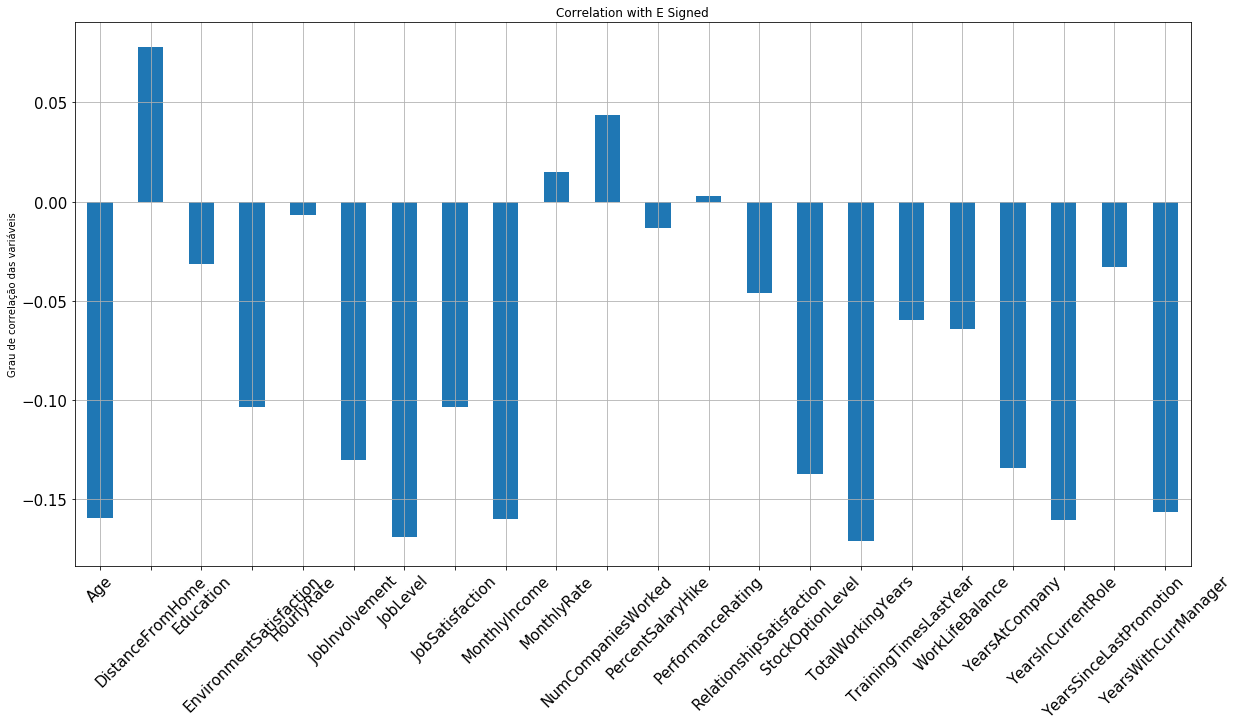

In [444]:
continuous_columns = ['Age','DistanceFromHome', 'Education', 'EnvironmentSatisfaction','HourlyRate','JobInvolvement','JobLevel','JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked','PercentSalaryHike',  'PerformanceRating', 'RelationshipSatisfaction','StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear','WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion','YearsWithCurrManager'] 
b=IBM[continuous_columns]

a=b.corrwith(IBM['Attrition']).plot.bar(
        figsize = (20,10), title = "Correlation with E Signed", fontsize = 15,
        rot = 45, grid = True)
plt.ylabel('Grau de correlação das variáveis');

Pode-se notar que a maioria de nossas variáveis tem correlação negativa com a principal(Attrition) o que nos leva a deduzir que quando uma aumenta, a outra diminui, mas o mais importante que pode ser retirado do gráfico feito é que a maioria de nossas variáveis não tem um grande impacto, já que o grau de correlação vai de 1 a -1 e no gráfico acima o máximo que temos é de 0.18

In [445]:
#Printando DataFrame para visualização dos parâmetros.
IBM.iloc[:,0:20].head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime
0,41,1,Travel_Rarely,Sales,1,2,Life Sciences,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes
1,49,0,Travel_Frequently,Research & Development,8,1,Life Sciences,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No
2,37,1,Travel_Rarely,Research & Development,2,2,Other,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes
3,33,0,Travel_Frequently,Research & Development,3,4,Life Sciences,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes
4,27,0,Travel_Rarely,Research & Development,2,1,Medical,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No


In [446]:
#Printando DataFrame para visualização dos parâmetros.
IBM.iloc[:,20:35].head()

,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,11,3,1,0,8,0,1,6,4,0,5
1,23,4,4,1,10,3,3,10,7,1,7
2,15,3,2,0,7,3,3,0,0,0,0
3,11,3,3,0,8,3,3,8,7,3,0
4,12,3,4,1,6,3,3,2,2,2,2


In [447]:
#DataFrame das pessoas com Sem Atrito com a empresa:
NoAttrition = IBM.loc[(IBM['Attrition']==0)]

#DataFrame das pessoas com Atrito com a empresa:
Attrition = IBM.loc[(IBM['Attrition']==1)]

In [448]:
IBM.iloc[:,0:20].head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime
0,41,1,Travel_Rarely,Sales,1,2,Life Sciences,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes
1,49,0,Travel_Frequently,Research & Development,8,1,Life Sciences,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No
2,37,1,Travel_Rarely,Research & Development,2,2,Other,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes
3,33,0,Travel_Frequently,Research & Development,3,4,Life Sciences,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes
4,27,0,Travel_Rarely,Research & Development,2,1,Medical,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No


___
* **Criando função para plotar os gráficos de pizza para comparar as variáveis qualitativas do DataFrame:**

In [449]:
#foi usado um def encontrado na internet como referencia, erro no codigo legenda errada
def plot(va) :

    colors = ['darkblue', 'darkorange', 'darkgreen', 'darkred', 'lightgrey', 'orange', 'white', 'lightpink']
    trace1 = go.Pie(values  = Attrition[va].value_counts().values.tolist(),
                    labels  = Attrition[va].value_counts().keys().tolist(),
                    textfont=dict(size=15), opacity = 0.8,
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "attrition employes",
                    marker  = dict(colors = colors, line = dict(width = 1.5)))
    trace2 = go.Pie(values  = NoAttrition[va].value_counts().values.tolist(),
                    labels  = NoAttrition[va].value_counts().keys().tolist(),
                    textfont=dict(size=15), opacity = 0.8,
                    hoverinfo = "label+percent+name",
                    marker  = dict(colors = colors, line = dict(width = 1.5)),
                    domain  = dict(x = [.52,1]),
                    name    = "Non attrition employes" )

    layout = go.Layout(dict(title = va + " distribution in employes attrition ",
                            annotations = [dict(text = "Yes_attrition",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .22, y = -0.1),
                                            dict(text = "No_attrition",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .8,y = -.1)]))
                                          

    fig  = go.Figure(data = [trace1,trace2],layout = layout)
    py.iplot(fig)

#### **Gráfico que mostra a quantidade de pessoas com attrition e sem da empresa**
**Estamos utilizando 1 como sendo que teve atrito e 0 como não**

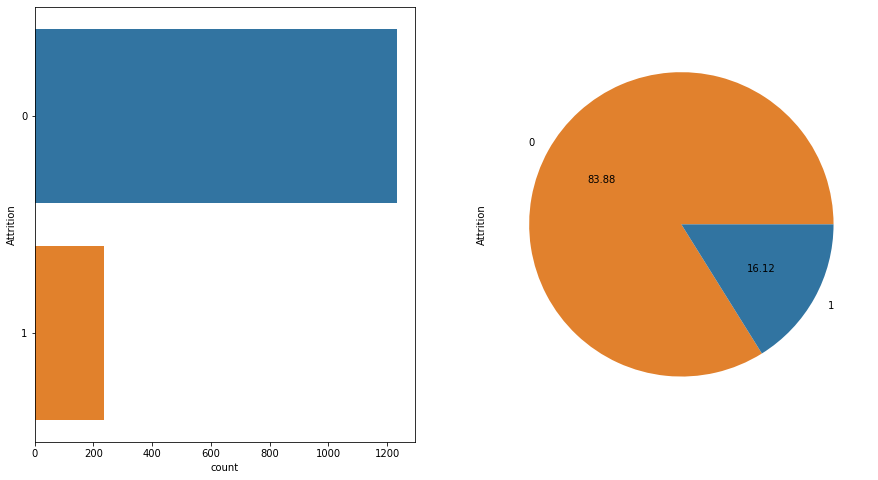

In [450]:
attri=IBM.Attrition.value_counts()
plt.figure(figsize=(15,8))
plt.subplot(121)
x = sns.countplot(y="Attrition",  data=IBM)
plt.subplot(122)
attri.plot(kind='pie', colors=('#E1812D','#3174A1'), autopct="%.2f", legend=False)

Como podemos notar, existe um desequilibrio entre as duas classes, esse desequilibrio prejudicara nossas técnicas que serão utilizdas para ML, ja que tais algoritmos tem dificuldade de aprender quando uma classe predomina a outra. Para resolver tal situação será utilizada o *SMOTE*(Synthetic Minority Over-sampling TEchnique line by line).

Pequeno artigo explicando como o Smoto funciona: http://rikunert.com/SMOTE_explained

___
* **Plotando os gráficos de pessoas que tem atrito e não tem atrito com a empresa, relacionando-as a satisfação dos funcionários com o trabalho:**
___

Legenda:

JobSatisfaction: 
* **1: Low** 
* **2: Medium**
* **3: High** 
* **4: Very High**

In [451]:
plot("JobSatisfaction")

___
* **Plotando os gráficos de pessoas que tem atrito e não tem atrito com a empresa, relacionando-as com seu estado civil:**
___

In [452]:
plot("MaritalStatus")

O gráfico de pizza acima mostra que a maior parte das pessoas que tem atrito com a empresa é solteiro, e a maior quantida de pessoas que não tem atrito são casados, o que pode estar a ver com que quando se está solteiro, as pessoas costumam a se arriscar mais

___
* **Plotando os gráficos de pessoas que tem atrito e não tem atrito com a empresa, relacionando-as a Gênero dos funcinários:**

In [453]:
plot("Gender")

___
* **Plotando o gráfico de pessoas que tem atrito e não tem atrito com a empresa, relacionando-as ao Número de Companias que a pessoa trabalhou antes:**

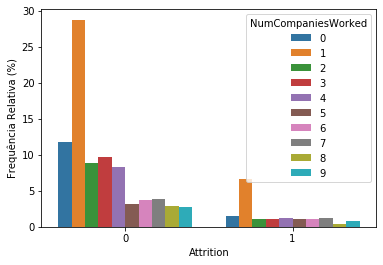

In [454]:
sns.barplot(x='Attrition',y="Attrition",hue="NumCompaniesWorked", data=IBM, estimator=lambda x: len(x) / len(IBM) * 100);
plt.ylabel('Frequência Relativa (%)');


___
* **Plotando o gráfico de pessoas que tem atrito e não tem atrito com a empresa, relacionando-as a Frequência que a pessoa viaja a trabalho:**

In [455]:
plot("BusinessTravel")

___
* **Plotando o gráfico de pessoas que tem atrito e não tem atrito com a empresa, relacionando-as a Área de Formação dos funcionários:**

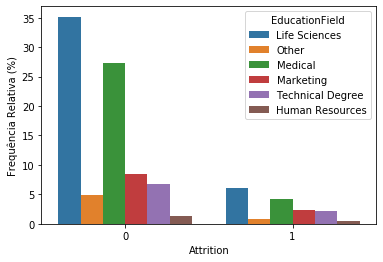

In [456]:
sns.barplot(x='Attrition',y="Attrition",hue="EducationField", data=IBM, estimator=lambda x: len(x) / len(IBM) * 100);
plt.ylabel('Frequência Relativa (%)');


___
* **Plotando o gráfico de pessoas que tem atrito e não tem atrito com a empresa, relacionando-as a Área de Trabalho dos funcionários:**

In [457]:
plot("JobRole")

Podemos ver que mesmo a maior quantidade de pessoas que tem atrito são técnicos de laboratorio, mesmo 

___
* **Plotando o gráfico de pessoas que tem atrito e não tem atrito, comparando-as se fazem hora extra ou não:**

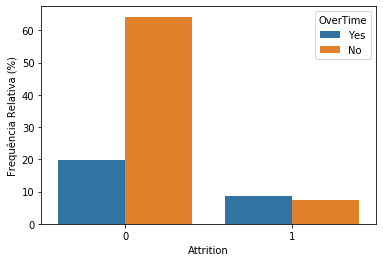

In [458]:
sns.barplot(x='Attrition',y="Attrition",hue="OverTime", data=IBM, estimator=lambda x: len(x) / len(IBM) * 100);
plt.ylabel('Frequência Relativa (%)');

Uma coisa interessante enquanto analisavamos nossas variáveis que não pensamos que seria assim, é que a maior quantidade das pessoas que não trabalham hora extra permanecem na empresa, sendo que o grupo acreditava que seria o contrário, otimo insight para a continuação do projeto

___
* **Plotando o gráfico de pessoas que tem atrito e não tem atrito com a empresa, relacionando-as com a perfomance do indivíduo:**

___
Legenda:

PerformanceRating: 
* **1: Low** 
* **2: Good**
* **3: Excellent** 
* **4: Outstanding**

In [459]:
plot("PerformanceRating")

O gráfico acima mostra que perfomance rating não é uma variável muito imporante para definir se o empregado terá ou não atrito com a empresa, o que nós fará a não considera-lo

___
* **Plotando o gráfico de pessoas que tem atrito e não tem atrito com a empresa, relacionando-as com StockOptionLevel (a empresa fornece ao funcionário a opção de adquirir as ações da empresa a um valor pré-determinado passado um certo período de tempo) :**

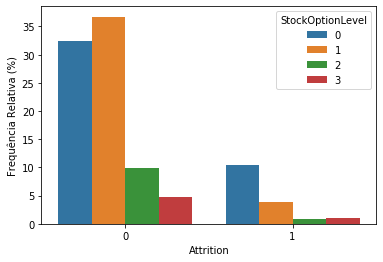

In [460]:
sns.barplot(x='Attrition',y="Attrition",hue="StockOptionLevel", data=IBM, estimator=lambda x: len(x) / len(IBM) * 100);
plot('StockOptionLevel')
plt.ylabel('Frequência Relativa (%)');

Os gráficos acima mostram que quando maior o StockOptionLevel da pessoa, menor a chance dele sair da empresa, talvez um desses motivos seja que o funcionário sente-se "um pouco dono da empresa", além disso mesmo a maior quantidade de pessoas que não tem atrito com a empresa estando no level 1, a maior frequencia das pessoas que tem atrito são as que não tem stock option.

___
* **Plotando o gráfico de pessoas que tem atrito e não tem atrito com a empresa, relacionando-as com o equilíbrio na vida de trabalho e vida pessoal:**
___
Legenda:

WorkLifeBalance: 
* **1: Bad** 
* **2: Good**
* **3: Better** 
* **4: Best**

In [461]:
plot("WorkLifeBalance")

___
* **Histograma que mostra os anos na mesma posição de trabalho:**

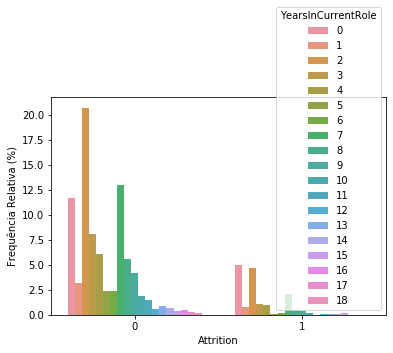

In [462]:
sns.barplot(x='Attrition',y="Attrition",hue="YearsInCurrentRole", data=IBM, estimator=lambda x: len(x) / len(IBM) * 100);
plt.ylabel('Frequência Relativa (%)');

___
* **Histograma que motra a frequência relativa dos funcionários desde a última promoção:**

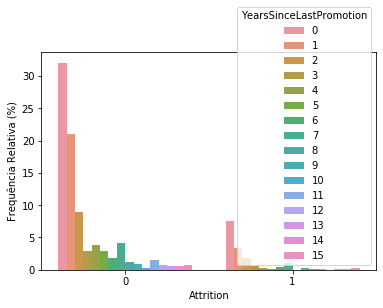

In [463]:
sns.barplot(x='Attrition',y="Attrition",hue="YearsSinceLastPromotion", data=IBM, estimator=lambda x: len(x) / len(IBM) * 100);
plt.ylabel('Frequência Relativa (%)');

___
* **Histograma com a frequência relativa dos funcionários com seu gerente atual**

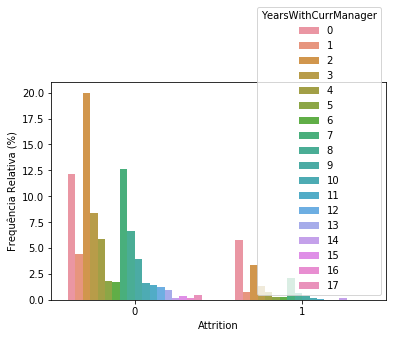

In [464]:
sns.barplot(x='Attrition',y="Attrition",hue="YearsWithCurrManager", data=IBM, estimator=lambda x: len(x) / len(IBM) * 100);
plt.ylabel('Frequência Relativa (%)');

___
* **Gráfico com a frequência relativa dos funcionários na empresa:**

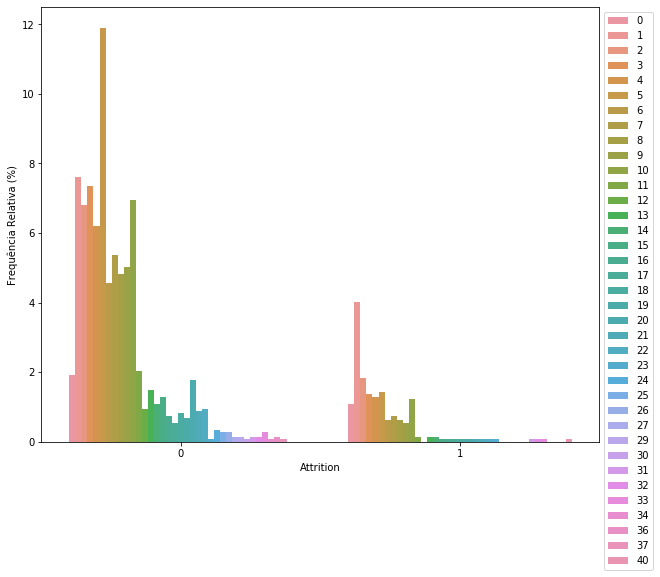

In [465]:
plt.figure(figsize=(10,8))
sns.barplot(x='Attrition',y="Attrition",hue="YearsAtCompany", data=IBM, estimator=lambda x: len(x) / len(IBM) * 100);
plt.legend(loc='best',bbox_to_anchor=(1,1))
plt.ylabel('Frequência Relativa (%)');

___
* ### Gráficos de violino para a comparação entre variável quantitativa x qualitativa:

Gráficos de violino são semelhantes a boxplot, mas com a adição de um gráfico de densidade de kernel adicionado a cada lado

___
* **Gráfico comparando Atrito na Empresa X Distância da casa dos funcionários até a empresa:**

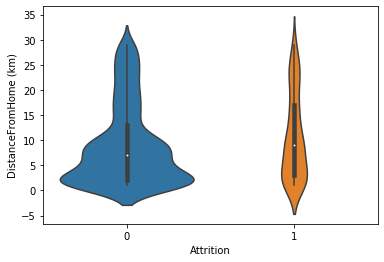

In [466]:
sns.violinplot(x="Attrition", y="DistanceFromHome", data=IBM, scale='count');
plt.ylabel('DistanceFromHome (km)');

___
* **Gráfico comparando Atrito na Empresa X Salário Mensal em U$ dos funcionários:**

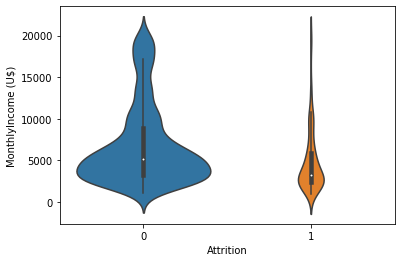

In [467]:
sns.violinplot(x="Attrition", y="MonthlyIncome", data=IBM,scale="count");
plt.ylabel('MonthlyIncome (U$)');

___
* **Gráfico comparando Atrito na Empresa X Renda por hora em U$ dos funcionários:**

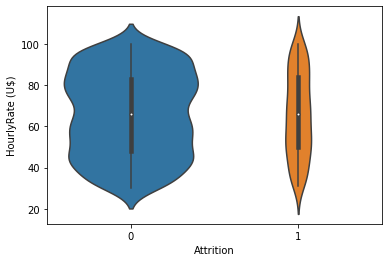

In [468]:
sns.violinplot(x="Attrition", y="HourlyRate", data=IBM,scale='count');
plt.ylabel('HourlyRate (U$)');

___
* **Gráfico comparando Atrito na Empresa X Porcentagem de aumento de salário dos funcionários:**

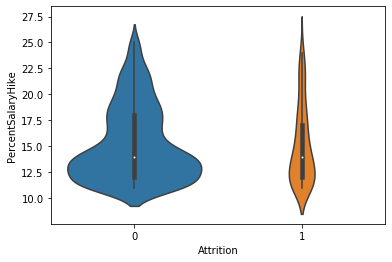

In [469]:
sns.violinplot(x="Attrition", y="PercentSalaryHike", data=IBM, scale='count');

___
* **Gráfico comparando Atrito na Empresa X Renda por mês em U$ dos funcionários:**

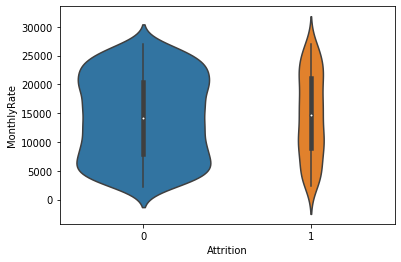

In [470]:
sns.violinplot(x="Attrition", y="MonthlyRate", data=IBM, scale='count');

___
* ## **Decision Tree**

In [471]:
'''
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
'''

'\nfrom sklearn import tree\nfrom sklearn.tree import DecisionTreeClassifier\n'

In [472]:

x = IBM['Attrition']
y = IBM[['JobInvolvement','JobLevel','EnvironmentSatisfaction','Education','DistanceFromHome','Department','BusinessTravel','HourlyRate','MonthlyIncome']]

In [473]:
'''
X = IBM[['MonthlyIncome','Age','DistanceFromHome','Department']]
y = IBM['Attrition']
decisiontree = tree.DecisionTreeClassifier(random_state=0, max_depth=2)
decisiontree = decisiontree.fit(X,y)
pd.crosstab(decisiontree,target_val,normalize='columns')
'''

"\nX = IBM[['MonthlyIncome','Age','DistanceFromHome','Department']]\ny = IBM['Attrition']\ndecisiontree = tree.DecisionTreeClassifier(random_state=0, max_depth=2)\ndecisiontree = decisiontree.fit(X,y)\npd.crosstab(decisiontree,target_val,normalize='columns')\n"

___
* ## *Preparando nosso dataset para podermos utilizar ml*





In [474]:
#Para utilizar esses metódos e outros, devemos trocar nossas  variaveis categoricas em dummys e separar o nosso teste(data) 
#com o target, que será o que procuramos, ou seja: Attrition
quali = []

teste=IBM.drop(["Attrition"], axis=1)
teste.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Travel_Rarely,Sales,1,2,Life Sciences,1,2,Female,94,...,3,1,0,8,0,1,6,4,0,5
1,49,Travel_Frequently,Research & Development,8,1,Life Sciences,2,3,Male,61,...,4,4,1,10,3,3,10,7,1,7
2,37,Travel_Rarely,Research & Development,2,2,Other,4,4,Male,92,...,3,2,0,7,3,3,0,0,0,0
3,33,Travel_Frequently,Research & Development,3,4,Life Sciences,5,4,Female,56,...,3,3,0,8,3,3,8,7,3,0
4,27,Travel_Rarely,Research & Development,2,1,Medical,7,1,Male,40,...,3,4,1,6,3,3,2,2,2,2


In [475]:
teste = pd.get_dummies(teste)


In [476]:
target=IBM['Attrition']


In [477]:
#Splita nosso teste e target em treino e teste, como pode-se notar, o train_size é o tamanho de sua amostra de treino, que
#deve ser maior do que sua teste, o recomendado é 66%, pelo livro hands-on machine learning with scikit-learn and tensorflow
#ou 75%
train, test, target_train, target_val = train_test_split(teste, target, train_size= 0.66,random_state=0);



<img src="files/img/smote.png">

In [478]:
#SMOTE-balanceia as variaveis, como vimos em nossa análise exploratoria, a quantidade de pessoas que não tem attriton é mui
#to superior as que tem attrition(84%, 16%),uma amostra desbalanceada, e por tal motivo, é necessário utilizar alguma 
#técnica para balancear nossa amostra, pode-se utilizar SMOTE(oversampler) ou NearMiss(undersampler)

oversampler=SMOTE(random_state=0)
smote_train, smote_target = oversampler.fit_sample(train,target_train)


In [479]:
bin1 = np.bincount(target_train)
bin2 = np.bincount(smote_target)
print('Amostra original=',bin1)
print('Amostra após utilizar o smote:',bin2)
#Pode-se ver que o SMOTE para balancear a quantidade de attriton e no attriton, criou novas "amostras" sinteticas

Amostra original= [813 157]
Amostra após utilizar o smote: [813 813]


___
* ## *Random Forest*

**O que é?**

Random Forest é um algoritmo de aprendizagem supervisionada que cria uma floresta de um modo aleatório, unindo diversas árvores de decisão, utilizando  o metódo de bagging. Esse algoritmo é muito utilizado atualmente ja que ele pode ser utilizado para tarefas de regressão e classificação


In [510]:
seed = 0   # We set our random seed to zero for reproducibility
# Random Forest parameters
rf2_params = {
    'n_jobs': -1,
    'n_estimators': 1000,
    'warm_start': True, 
    'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'random_state' : seed,
    'verbose': 1
}

rf2 = RandomForestClassifier(**rf2_params)
rf2.fit(smote_train, smote_target)
rf2_predictions = rf2.predict(test)
accuracy_score(target_val, rf2_predictions)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.868

In [511]:
y = rf.feature_importances_
x=teste.columns.values
fig = px.scatter( x=x, y=y,color=y,
                  color_continuous_scale='Cividis')

fig.show()


In [512]:
prediction = pd.Series(rf2_predictions)
pd.crosstab(prediction,target_val,normalize='columns')

Attrition,0,1
row_0,,
0,0.900709,0.913043
1,0.099291,0.086957


## Gradient Boost

O Gradient Boost é um grupo de algoritmos de machine learning que combina modelos de predição "fracos" para criar um modelo forte. (Generaliza nossa amostra)

In [485]:
gradient = XGBClassifier()
gradient.fit(train, target_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [486]:
# make predictions for test data
y_pred = gradient.predict(test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_pred, target_val)
print("Accuracy: %.2f%%" % (accuracy * 100.0))



pd.crosstab(y_pred,target_val,normalize='columns')

Accuracy: 87.60%


Attrition,0,1
row_0,,
0,0.980952,0.675
1,0.019048,0.325


In [487]:
gradient.get_booster().get_score(importance_type="gain")
#fazer o plotly

{'OverTime_No': 8.04813430536111,
 'MonthlyIncome': 4.995825808352114,
 'JobRole_Research Scientist': 4.035905798333333,
 'MaritalStatus_Single': 6.589019389999999,
 'TotalWorkingYears': 5.001026135,
 'HourlyRate': 3.162139575238095,
 'WorkLifeBalance': 4.107986078750001,
 'YearsAtCompany': 3.1365421209523805,
 'JobInvolvement': 3.4519373814736847,
 'StockOptionLevel': 6.2804629045,
 'DistanceFromHome': 3.6126385684999986,
 'YearsWithCurrManager': 6.096704824285714,
 'EnvironmentSatisfaction': 3.842874971444444,
 'Age': 5.191996949698149,
 'BusinessTravel_Travel_Frequently': 4.9260741046153855,
 'JobLevel': 8.273412216999999,
 'YearsInCurrentRole': 2.917276183333333,
 'JobSatisfaction': 3.2480150842,
 'NumCompaniesWorked': 4.293732681875,
 'JobRole_Sales Executive': 6.709451578571428,
 'RelationshipSatisfaction': 3.50854608268,
 'EmployeeNumber': 3.0623509652619054,
 'BusinessTravel_Non-Travel': 2.532826561428571,
 'PercentSalaryHike': 3.142859396666667,
 'MonthlyRate': 2.7805756090277

## Gradient  com SMOTE


In [488]:
gradient2 = XGBClassifier()
gradient2.fit(smote_train, smote_target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

___
* ## *Regressão Logistica*



In [489]:
reg = linear_model.LogisticRegression() 


In [490]:
reg.fit(train, target_train) 
y_pred = reg.predict(test) 


C:\Users\Willian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [491]:
metrics.accuracy_score(target_val,y_pred) 


0.88

In [492]:

pd.crosstab(y_pred,target_val,normalize='columns')

Attrition,0,1
row_0,,
0,0.990476,0.7
1,0.009524,0.3


# Regressão Logistica com SMOTE

In [493]:
reg2 = linear_model.LogisticRegression() 
reg2.fit(smote_train, smote_target) 
y_pred2 = reg2.predict(test) 


C:\Users\Willian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [494]:
metrics.accuracy_score(target_val,y_pred2) 


0.86

In [495]:
pd.crosstab(y_pred,target_val,normalize='columns')

Attrition,0,1
row_0,,
0,0.990476,0.7
1,0.009524,0.3


* ## *SVM*
 
 
 # Colocar SVM  no final do notebook, demora

In [496]:

#svclassifier = SVC(kernel='linear')
#svclassifier.fit(train, target_train)
#y_pred = svclassifier.predict(test)


In [497]:
#print(confusion_matrix(target_val,y_pred))
#print(classification_report(target_val,y_pred))

In [498]:
#pd.crosstab(y_pred,target_val,normalize='columns')

In [499]:
#svclassifier1 = SVC(kernel='sigmoid')
#svclassifier1.fit(train, target_train)
#y_pred1 = svclassifier1.predict(test)

In [500]:
#print(confusion_matrix(target_val,y_pred1))
#print(classification_report(target_val,y_pred1))

In [501]:
#pd.crosstab(y_pred1,target_val,normalize='columns')

 # SVM com SMOTE

In [502]:
'''
svclassifier2 = SVC(kernel='linear')
svclassifier2.fit(smote_train, smote_target)
y_pred3 = svclassifier2.predict(test)
print(confusion_matrix(target_val,y_pred3))
print(classification_report(target_val,y_pred3))

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-502-32a1fb74c1ea>, line 6)

In [ ]:
'''
pd.crosstab(y_pred3,target_val,normalize='columns')

Tentando aumentar as chancer de 1 e 1 serem verdadeiras

# sgd CLASSIFIER


In [ ]:
from sklearn.linear_model import SGDClassifier


In [ ]:
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=10000)
clf.fit(smote_train, smote_target) 
y_pred5=clf.predict(test)

In [ ]:
pd.crosstab(y_pred5,target_val,normalize='columns')

gaussian

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor